In [1]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import shap

In [22]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_95080/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [ ]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True).astype(float)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)
print('Types of variables in bp_category:',df['bp_category'].nunique())

#Drop Blood pressure colums including systolic and diastolic
df = df.drop(columns=['blood_pressure', 'systolic', 'diastolic'])
#df = df.drop(columns=['blood_pressure'])

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#omit_cols = ['blood_pressure', 'systolic', 'diastolic']
#omit_cols = ['blood_pressure', 'systolic', 'diastolic', 'medical_issue', 'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed', 'blue-light_filter', 'daily_steps', 'sleep_quality', 'smoking']
# omit_cols = ['medical_issue',\
#     'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed',\
#         'blue-light_filter', 'daily_steps', 'sleep_quality', 'smoking',\
#             'sleep_duration', 'feel_sleepy_during_day', 'heart_rate', 'height',
#             'caffeine_consumption', 'weight', 'physical_activity', 'alcohol_consumption']
# df = df.drop(columns=omit_cols)

Types of variables in bp_category: 3
['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'bp_category']


In [37]:
#df.describe()

In [108]:
x=df.drop(['dry_eye_disease'],axis=1)
y=df['dry_eye_disease']


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

In [109]:
models = {
    "Random Forest Classifier": RandomForestClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(),
    "SGD Classifier": SGDClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Support Vector Classifier (SVC)": SVC(),
    "Nu-Support Vector Classifier": NuSVC(),
    "Linear SVC": LinearSVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis()
}

In [110]:
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("-" * 30)

Model: Random Forest Classifier
Accuracy: 70.16%
Precision: 68.37%
Recall: 70.16%
F1 Score: 65.32%
------------------------------
Model: Decision Tree Classifier
Accuracy: 56.04%
Precision: 57.31%
Recall: 56.04%
F1 Score: 56.60%
------------------------------
Model: AdaBoost Classifier
Accuracy: 69.16%
Precision: 67.36%
Recall: 69.16%
F1 Score: 62.37%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 70.20%
Precision: 68.48%
Recall: 70.20%
F1 Score: 65.29%
------------------------------
Model: Bagging Classifier
Accuracy: 61.12%
Precision: 60.22%
Recall: 61.12%
F1 Score: 60.62%
------------------------------
Model: Extra Trees Classifier
Accuracy: 69.70%
Precision: 67.56%
Recall: 69.70%
F1 Score: 64.86%
------------------------------
Model: Logistic Regression
Accuracy: 69.26%
Precision: 67.36%
Recall: 69.26%
F1 Score: 62.84%
------------------------------
Model: Ridge Classifier
Accuracy: 68.78%
Precision: 66.66%
Recall: 68.78%
F1 Score: 61.56%
-------------

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/2904713921.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Accuracy", y="Model", data=df_metrics, palette="Blues_r")


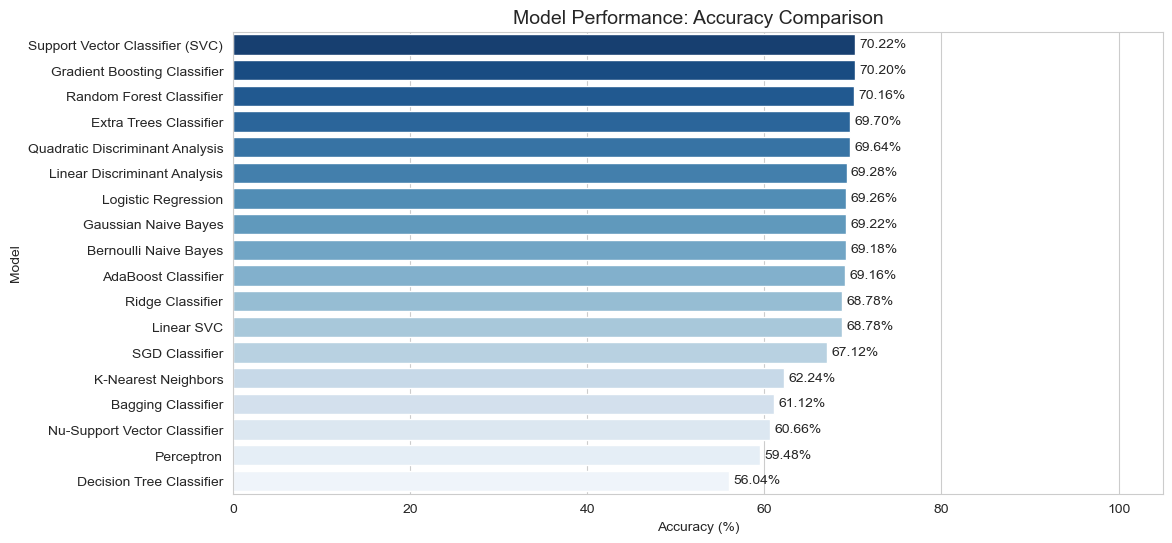

In [111]:
# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)

# Sort by accuracy in descending order
df_metrics = df_metrics.sort_values(by="Accuracy", ascending=False)

# Set style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="Accuracy", y="Model", data=df_metrics, palette="Blues_r")

# Add accuracy values on bars
for index, value in enumerate(df_metrics["Accuracy"]):
    ax.text(value + 0.5, index, f"{value:.2f}%", va="center", fontsize=10)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Model Performance: Accuracy Comparison", fontsize=14)
plt.xlim(0, 105)  # Extend limit slightly for better text visibility

plt.show()

# For Logistic Regression only

In [112]:
num_iter = [1, 5, 10, 50, 100, 200]
solver_arr = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/3930433787.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


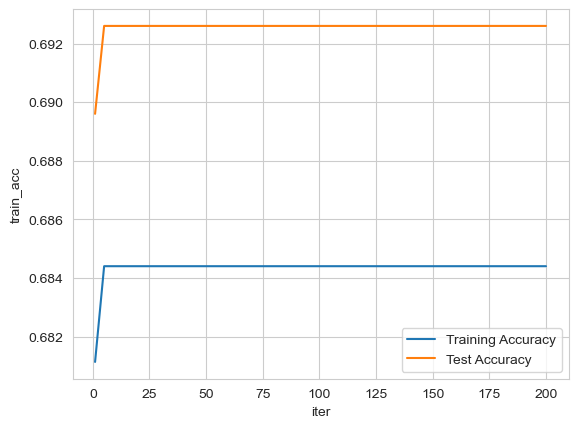

In [113]:
acc_test=[]

for iter in num_iter:
    lr = LogisticRegression(max_iter=iter, random_state=42)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    y_c = lr.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([iter, acc_yc, acc])
    
    # print(f"Accuracy: {acc * 100:.2f}%")
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    # print("-" * 30)
df_test = pd.DataFrame(acc_test, columns=['iter', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='iter', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='iter', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
ax.set_xscale('log')
ax.legend()
plt.show() 
    

newton-cg
lbfgs
liblinear
sag
saga


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/1419083009.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


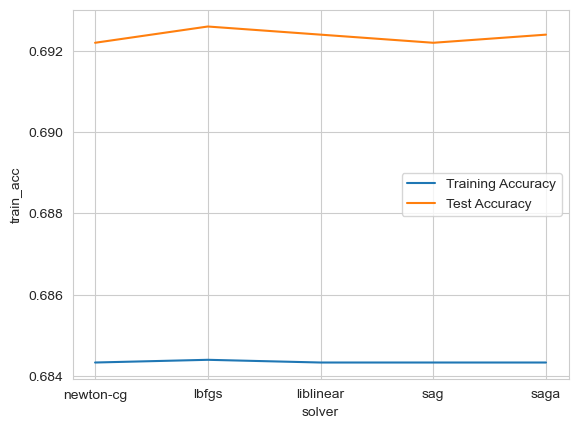

In [114]:
acc_test=[]

for solver in solver_arr:
    print(solver)
    lr = LogisticRegression(max_iter=1000, solver=solver, random_state=42)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    y_c = lr.predict(x_train)
    
    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([solver, acc_yc, acc])
    # print(f"Accuracy: {acc * 100:.2f}%")
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    # print("-" * 30)
    

df_test = pd.DataFrame(acc_test, columns=['solver', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='solver', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='solver', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
ax.set_xscale('log')
ax.legend()
plt.show() 

# For Random Forest Classifier

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/737068351.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


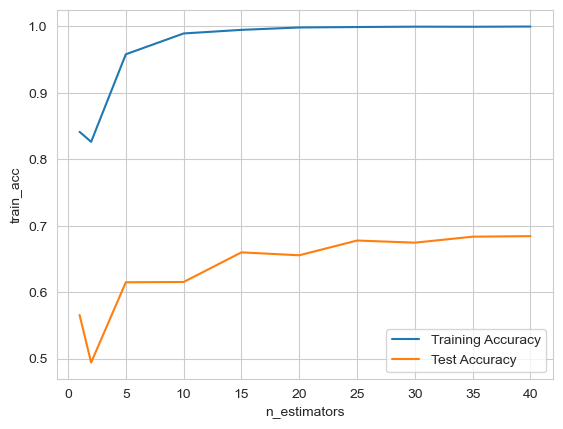

In [115]:
n_est = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]


acc_test=[]

for est in n_est:
    model = RandomForestClassifier(n_estimators=est, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([est, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['n_estimators', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='n_estimators', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='n_estimators', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show() 
    

# Support Vector Classifier

linear


/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


poly
rbf
sigmoid


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/2573717689.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


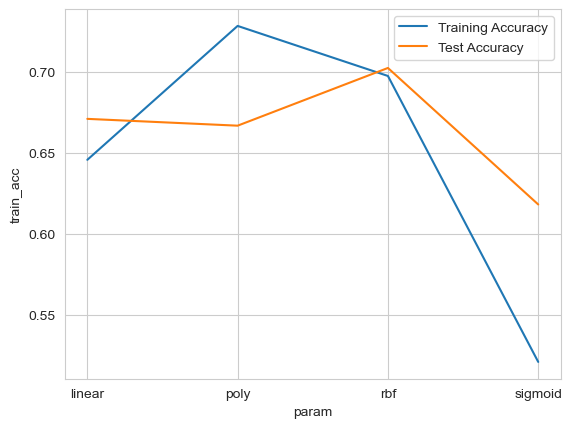

In [118]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']


acc_test=[]

for parm in kernel:
    print(parm)
    model = SVC(kernel=parm, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([parm, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['param', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='param', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='param', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show()

# Gradient Boosting Classifier

10
20
50
100
200
500
1000


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/3892899656.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


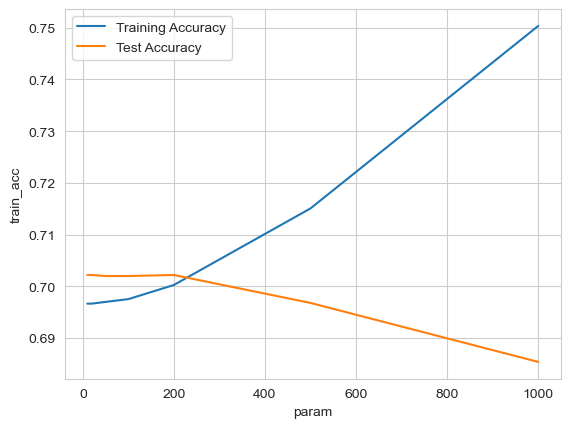

In [119]:
n_est = [10, 20, 50, 100, 200, 500, 1000]

acc_test=[]

for parm in n_est:
    print(parm)
    model = GradientBoostingClassifier(n_estimators=parm, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([parm, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['param', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='param', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='param', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show()

2
3
4
5
6
7
8
9
10


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/3120812114.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


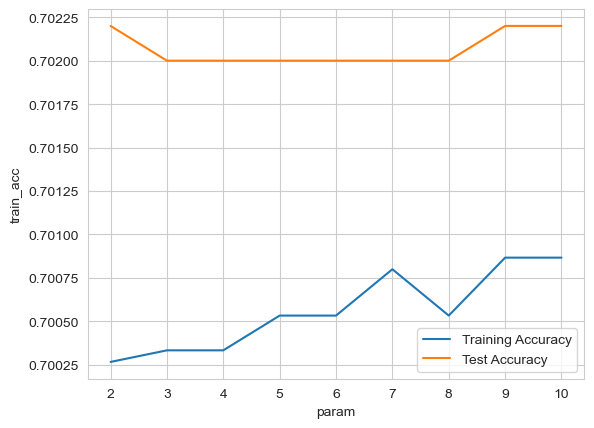

In [121]:
samp_split = [2, 3, 4, 5 ,6, 7, 8, 9, 10]

acc_test=[]

for parm in samp_split:
    print(parm)
    model = GradientBoostingClassifier(n_estimators=200, min_samples_split=parm, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([parm, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['param', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='param', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='param', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show()

2
3
4
5
6
7
8
9
10


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/1508438524.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


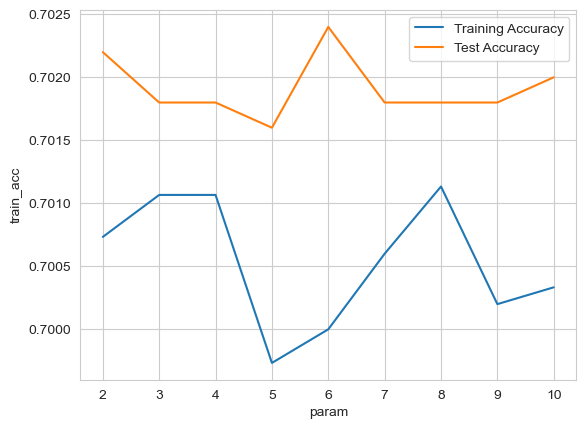

In [122]:
samples_leaf = [2, 3, 4, 5 ,6, 7, 8, 9, 10]

acc_test=[]

for parm in samples_leaf:
    print(parm)
    model = GradientBoostingClassifier(n_estimators=200, min_samples_split=9, min_samples_leaf=parm, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([parm, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['param', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='param', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='param', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show()

1
2
3
4
5
6
7
8
9
10


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_4743/2243292988.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


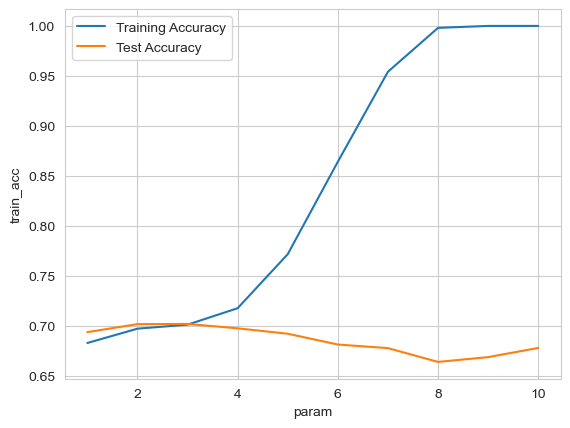

In [123]:
depth = [1, 2, 3, 4, 5 ,6, 7, 8, 9, 10]

acc_test=[]

for parm in depth:
    print(parm)
    model = GradientBoostingClassifier(n_estimators=200, min_samples_split=9, min_samples_leaf=3, max_depth=parm, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_c = model.predict(x_train)

    acc = accuracy_score(y_test, y_pred)
    acc_yc = accuracy_score(y_train, y_c)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    acc_test.append([parm, acc_yc, acc])

df_test = pd.DataFrame(acc_test, columns=['param', 'train_acc', 'test_acc'])

fig, axes = plt.subplots()
sns.lineplot(x='param', y='train_acc', data = df_test, ax=axes, label='Training Accuracy')
sns.lineplot(x='param', y='test_acc', data = df_test, ax=axes, label='Test Accuracy')
#ax.set_xscale('log')
ax.legend()
plt.show()

In [76]:
# X=df.drop(['sleep_disorder'],axis=1)
# y=df['sleep_disorder']

X=df.drop(['dry_eye_disease'],axis=1)
y=df['dry_eye_disease']

# Encode categorical features and scale numerical ones
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# 3. Define PyTorch Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)  # For classification
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 4. Define the neural network
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = DryEyeNet(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 6. Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

Epoch 1/100, Loss: 0.5800
Epoch 2/100, Loss: 0.5672
Epoch 3/100, Loss: 0.5363
Epoch 4/100, Loss: 0.6783
Epoch 5/100, Loss: 0.5785
Epoch 6/100, Loss: 0.5595
Epoch 7/100, Loss: 0.6527
Epoch 8/100, Loss: 0.5808
Epoch 9/100, Loss: 0.5629
Epoch 10/100, Loss: 0.6915
Epoch 11/100, Loss: 0.7056
Epoch 12/100, Loss: 0.6874
Epoch 13/100, Loss: 0.6148
Epoch 14/100, Loss: 0.6619
Epoch 15/100, Loss: 0.4635
Epoch 16/100, Loss: 0.6201
Epoch 17/100, Loss: 0.6981
Epoch 18/100, Loss: 0.5777
Epoch 19/100, Loss: 0.6247
Epoch 20/100, Loss: 0.6367
Epoch 21/100, Loss: 0.6067
Epoch 22/100, Loss: 0.6607
Epoch 23/100, Loss: 0.4737
Epoch 24/100, Loss: 0.6820
Epoch 25/100, Loss: 0.5019
Epoch 26/100, Loss: 0.5597
Epoch 27/100, Loss: 0.5523
Epoch 28/100, Loss: 0.7042
Epoch 29/100, Loss: 0.5553
Epoch 30/100, Loss: 0.5831
Epoch 31/100, Loss: 0.6832
Epoch 32/100, Loss: 0.6799
Epoch 33/100, Loss: 0.5868
Epoch 34/100, Loss: 0.5354
Epoch 35/100, Loss: 0.7131
Epoch 36/100, Loss: 0.5637
Epoch 37/100, Loss: 0.6216
Epoch 38/1

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# # Assume df is already loaded
# X = df.drop(['dry_eye_disease'], axis=1)
# y = df['dry_eye_disease']

# # Encode categorical features and scale
# X = pd.get_dummies(X, drop_first=True)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Improved model
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

model = DryEyeNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

Epoch 1/300, Loss: 0.6419
Epoch 2/300, Loss: 0.6283
Epoch 3/300, Loss: 0.6205
Epoch 4/300, Loss: 0.6175
Epoch 5/300, Loss: 0.6169
Epoch 6/300, Loss: 0.6159
Epoch 7/300, Loss: 0.6115
Epoch 8/300, Loss: 0.6123
Epoch 9/300, Loss: 0.6113
Epoch 10/300, Loss: 0.6099
Epoch 11/300, Loss: 0.6081
Epoch 12/300, Loss: 0.6071
Epoch 13/300, Loss: 0.6078
Epoch 14/300, Loss: 0.6060
Epoch 15/300, Loss: 0.6061
Epoch 16/300, Loss: 0.6042
Epoch 17/300, Loss: 0.6040
Epoch 18/300, Loss: 0.6032
Epoch 19/300, Loss: 0.6014
Epoch 20/300, Loss: 0.5982
Epoch 21/300, Loss: 0.5989
Epoch 22/300, Loss: 0.5942
Epoch 23/300, Loss: 0.5969
Epoch 24/300, Loss: 0.5959
Epoch 25/300, Loss: 0.5939
Epoch 26/300, Loss: 0.5937
Epoch 27/300, Loss: 0.5926
Epoch 28/300, Loss: 0.5919
Epoch 29/300, Loss: 0.5933
Epoch 30/300, Loss: 0.5928
Epoch 31/300, Loss: 0.5922
Epoch 32/300, Loss: 0.5892
Epoch 33/300, Loss: 0.5883
Epoch 34/300, Loss: 0.5851
Epoch 35/300, Loss: 0.5874
Epoch 36/300, Loss: 0.5867
Epoch 37/300, Loss: 0.5868
Epoch 38/3

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# # Encode categorical features and scale
# X = pd.get_dummies(X, drop_first=True)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Improved model
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = DryEyeNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

Epoch 1/300, Loss: 0.6337
Epoch 2/300, Loss: 0.6213
Epoch 3/300, Loss: 0.6181
Epoch 4/300, Loss: 0.6183
Epoch 5/300, Loss: 0.6162
Epoch 6/300, Loss: 0.6163
Epoch 7/300, Loss: 0.6154
Epoch 8/300, Loss: 0.6163
Epoch 9/300, Loss: 0.6154
Epoch 10/300, Loss: 0.6151
Epoch 11/300, Loss: 0.6144
Epoch 12/300, Loss: 0.6148
Epoch 13/300, Loss: 0.6141
Epoch 14/300, Loss: 0.6141
Epoch 15/300, Loss: 0.6141
Epoch 16/300, Loss: 0.6141
Epoch 17/300, Loss: 0.6137
Epoch 18/300, Loss: 0.6145
Epoch 19/300, Loss: 0.6136
Epoch 20/300, Loss: 0.6133
Epoch 21/300, Loss: 0.6133
Epoch 22/300, Loss: 0.6127
Epoch 23/300, Loss: 0.6136
Epoch 24/300, Loss: 0.6134
Epoch 25/300, Loss: 0.6128
Epoch 26/300, Loss: 0.6124
Epoch 27/300, Loss: 0.6124
Epoch 28/300, Loss: 0.6125
Epoch 29/300, Loss: 0.6131
Epoch 30/300, Loss: 0.6122
Epoch 31/300, Loss: 0.6128
Epoch 32/300, Loss: 0.6111
Epoch 33/300, Loss: 0.6127
Epoch 34/300, Loss: 0.6122
Epoch 35/300, Loss: 0.6123
Epoch 36/300, Loss: 0.6122
Epoch 37/300, Loss: 0.6122
Epoch 38/3

In [41]:
# from pytorch_tabnet.tab_model import TabNetClassifier

# clf = TabNetClassifier()
# clf.fit(X_train, y_train.values, eval_set=[(X_test, y_test.values)], max_epochs=100)

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import tanh

In [70]:
model = Sequential(
    [ 
        Dense(64, activation = 'tanh'),
        Dense(32, activation = LeakyReLU (negative_slope=0.9)),
        Dense(32, activation = 'tanh'),
        Dense(16, activation = LeakyReLU (negative_slope=0.9)),
        Dense(1, activation = 'tanh')   
    ]
)

# splitting data to train, val and test sets
X_train, X_, y_train, y_ = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
# Split the 20% subset above into two
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [71]:
model.compile(loss = "binary_crossentropy",
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0002),
        metrics=[keras.metrics.BinaryAccuracy()]) 

early_stopping = callbacks.EarlyStopping(
monitor='val_loss',
patience=10, 
restore_best_weights=True)


model.fit(
        X_train, y_train,
        validation_data=(X_val, y_test),
        epochs=100,
        callbacks=[early_stopping],
        verbose=0)

print(f"Max validation accurancy: {(max(model.history.history['val_binary_accuracy'])):.2f}")

Max validation accurancy: 0.64


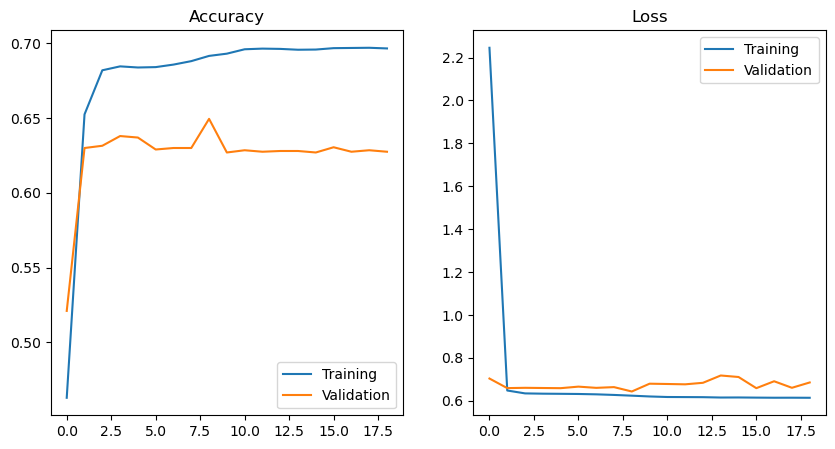

In [66]:
fig, (plt_acc, plt_loss) = plt.subplots(1, 2, figsize=(10, 5))
    
history = model.history.history
plt_acc.plot(history['binary_accuracy'], label="Training")
plt_acc.plot(history['val_binary_accuracy'], label="Validation")
 
plt_loss.plot(history['loss'], label="Training")
plt_loss.plot(history['val_loss'], label="Validation")
    
plt_acc.set_title("Accuracy")
plt_loss.set_title("Loss")
plt_acc.legend()
plt_loss.legend()

In [72]:
ypred_val = model.predict(X_val)

best_threshold = 0
best_F1 = 0
    
step_size = (np.max(ypred_val) - np.min(ypred_val)) / 10000
    
for threshold in np.arange(np.min(ypred_val), np.max(ypred_val), step_size):
        
    yhat_val = ypred_val>=threshold
    F1 = f1_score(y_val, yhat_val, average='weighted', zero_division=0)
    
    if F1 > best_F1:
        best_F1 = F1
        best_threshold = threshold
        
print(f"best_threshold: {best_threshold:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
best_threshold: 0.53


In [73]:
ypred_test = model.predict(X_test)
yhat_test = np.where(ypred_test >= best_threshold, 1, 0).flatten()
error_test = np.mean(yhat_test != y_test) *100  #error = misclassified/num_predictions
print(f"Test_Error: {error_test:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
Test_Error: 30.20%


In [74]:
print(f"Accuracy on the test set: {(accuracy_score(y_test, yhat_test)):.2f}")
print(f"Precision: {(precision_score(y_test, yhat_test, average='weighted', zero_division=0)):.2f}")
print(f"Recall: {(recall_score(y_test, yhat_test, average='weighted', zero_division=0)):.2f}")
print(f"F1: {(f1_score(y_test, yhat_test, average='weighted', zero_division=0)):.2f}")


Accuracy on the test set: 0.70
Precision: 0.67
Recall: 0.70
F1: 0.64


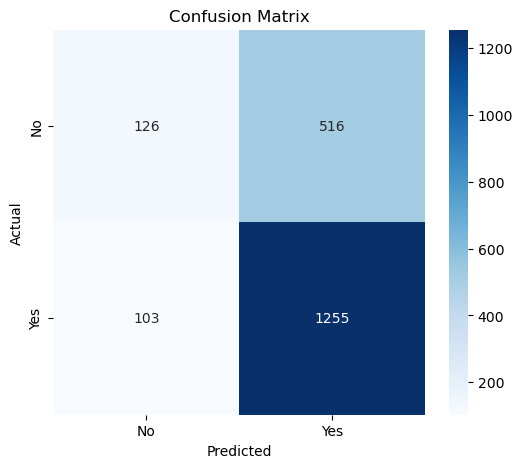

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

cm = confusion_matrix(y_test, yhat_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'],  
            yticklabels=['No', 'Yes'])  

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()